# Projet 4 : Anticipez les besoins en consommation de bâtiments
Date début : 12/12/2024

# Importation des librairies utiles

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
%matplotlib inline

import seaborn as sns

import math

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
import statsmodels.api as sm

import csv

from scipy import stats

import missingno as msno

In [2]:
from sklearn import linear_model

In [3]:
from sklearn.svm import SVR

In [4]:
from sklearn.ensemble import RandomForestRegressor

In [5]:
from sklearn.ensemble import GradientBoostingRegressor

In [6]:
from sklearn.metrics import r2_score

In [7]:
from sklearn import model_selection

In [8]:
data_folder = "D:/GoogleDrive/Mon Drive/GitProjets/openClassrooms/P4_besoinsConsommation/"
os.chdir(os.path.dirname(data_folder))

In [9]:
%run Durand_Jonathan_0_notebook_fonctions_122024.ipynb

In [10]:
name_models = ['baseline', 'ridge', 'lasso', 'EN', 'SVR', 'RFR', 'GBR']

# Variable de prédiction

In [11]:
goal = 'goal1'

In [12]:
threshold1 = 1000
threshold2 = 6000
bins_width = 100
bins_int_width = 0.5

In [13]:
coef_s = 1/1000

# Préparation des données

## Chargement des données

In [14]:
data_folder = "D:/GoogleDrive/Mon Drive/formations/OpenClassrooms/P4/"
os.chdir(os.path.dirname(data_folder))

In [15]:
data_pred = pd.read_csv('data_pred.csv', index_col='index')

In [16]:
data_pred_variables = pd.read_csv('data_pred_variables.csv', header=None)[0].values
data_pred_int_variables = pd.read_csv('data_pred_int_variables.csv', header=None)[0].values

In [17]:
data_pred_columns = data_pred.columns

In [18]:
data_pred['strat'] = sum([(data_pred[goal]>=threshold1),(data_pred[goal]>=threshold2)])

In [19]:
data_pred_star = data_pred.loc[~data_pred['ENERGYSTARScore'].isnull()]

In [20]:
data_pred_star.shape

(1046, 95)

## Sratification

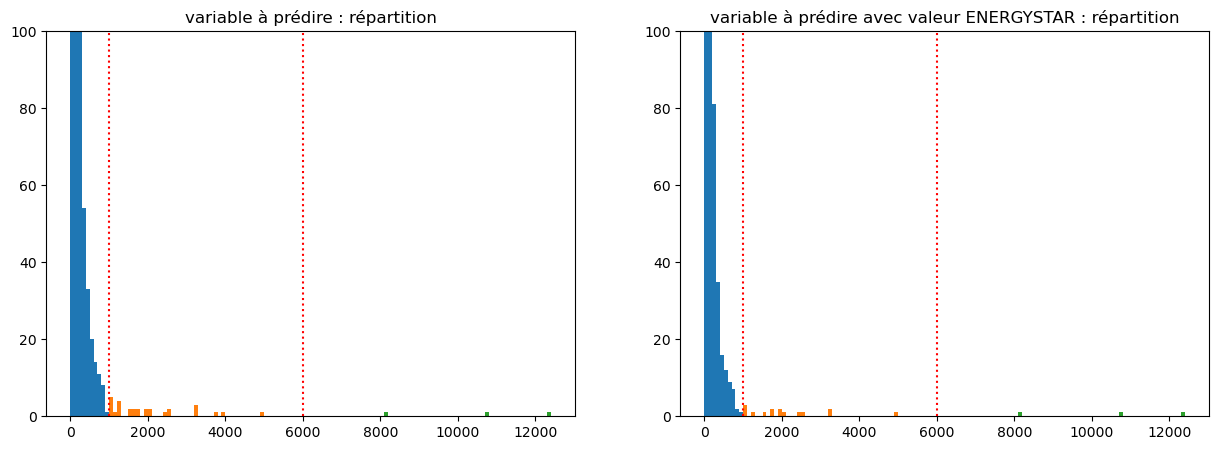

In [21]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,2,1)
ax.hist(data_pred.loc[data_pred['strat']==0][goal], bins=np.arange(0,threshold1+bins_width, bins_width))
ax.hist(data_pred.loc[data_pred['strat']==1][goal], bins=np.arange(threshold1,threshold2+bins_width, bins_width))
ax.hist(data_pred.loc[data_pred['strat']==2][goal], bins=np.arange(threshold2,data_pred[goal].max()+bins_width, bins_width))
plt.ylim([0,100])
ax.axvline(threshold1, linestyle=':', color='r')
ax.axvline(threshold2, linestyle=':', color='r')
ax.set_title('variable à prédire : répartition')

ax=plt.subplot(1,2,2)
ax.hist(data_pred_star.loc[data_pred_star['strat']==0][goal], bins=np.arange(0,threshold1+bins_width, bins_width))
ax.hist(data_pred_star.loc[data_pred_star['strat']==1][goal], bins=np.arange(threshold1,threshold2+bins_width, bins_width))
ax.hist(data_pred_star.loc[data_pred_star['strat']==2][goal], bins=np.arange(threshold2,data_pred[goal].max()+bins_width, bins_width))
plt.ylim([0,100])
ax.axvline(threshold1, linestyle=':', color='r')
ax.axvline(threshold2, linestyle=':', color='r')
ax.set_title('variable à prédire avec valeur ENERGYSTAR : répartition')

plt.show()

## Découpage des données (train/test)

In [22]:
X_strat = data_pred.loc[:, data_pred.columns!='strat'].values
y_strat = data_pred['strat']

In [23]:
X_strat_train, X_strat_test, y_strat_train, y_strat_test = model_selection.train_test_split(X_strat, y_strat, stratify=y_strat, test_size=0.3)

In [24]:
data_pred_train = pd.DataFrame(data=X_strat_train, columns=data_pred_columns)
data_pred_test = pd.DataFrame(data=X_strat_test, columns=data_pred_columns)

In [25]:
X_train = data_pred_train[data_pred_variables].values
X_test = data_pred_test[data_pred_variables].values
X_int_train = data_pred_train[data_pred_int_variables].values
X_int_test = data_pred_test[data_pred_int_variables].values

In [26]:
s_int_train = data_pred_train['s_int'].values*coef_s
s_int_test = data_pred_test['s_int'].values*coef_s

In [165]:
y_train = data_pred_train[goal].values
y_test = data_pred_test[goal].values
y_int_train = data_pred_train[goal+'_int'].values
y_int_test = data_pred_test[goal+'_int'].values

## Standardisation et normalisation des données

In [28]:
y_norm_train = np.log10(y_train)
y_norm_test = np.log10(y_test)

In [29]:
X_train_std, X_test_std = std_x(X_train, X_test)

In [30]:
X_int_train_std, X_int_test_std = std_x(X_int_train, X_int_test)

# Prédiction

## Préparation de la validation croisée

In [31]:
score = 'neg_mean_squared_error'

### Grilles de validation

In [32]:
param_grid_dict={}

#### Ridge

In [33]:
n_alphas = 200
alphas = np.logspace(-10, 5, n_alphas)

In [34]:
param_grid_dict['ridge'] = {'alpha':alphas}

#### Lasso

In [35]:
n_alphas = 300
alphas = np.logspace(-10, 1, n_alphas)

In [36]:
param_grid_dict['lasso'] = {'alpha':alphas}

#### Elstic Net

In [37]:
n_alphas = 50
alphas = np.logspace(-5, 2, n_alphas)
n_l1_ratio = 50
l1_ratios = np.logspace(-5, 2, n_l1_ratio)

In [38]:
param_grid_dict['EN'] = {'alpha':alphas, 'l1_ratio':l1_ratios}

#### Non linéaires

In [39]:
param_grid_dict['SVR'] = {'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),
                  'C' : [1,5,10, 50],'degree' : [3,8],
                  'coef0' : [0.01,0.5,10, 20, 50],
                  'gamma' : ('auto','scale')}

In [40]:
param_grid_dict['RFR'] = {'n_estimators':[50, 100, 150, 200], 'max_depth':[50,70,100]}

In [41]:
param_grid_dict['GBR'] = {'n_estimators':[50, 100, 150, 200], 'learning_rate':[0.0, 0.2, 0.5, 0.7, 1]}

## Modèle complet

In [42]:
Y_train_complet, Y_complet, lr_complet, clf_complet = prediction_tot(X_train_std, y_train, X_test_std, param_grid_dict, score)

D:\logiciels\Python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.931e+07, tolerance: 7.841e+03
  model = cd_fast.enet_coordinate_descent(
D:\logiciels\Python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.718e+07, tolerance: 2.773e+04
  model = cd_fast.enet_coordinate_descent(
D:\logiciels\Python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.179e+07, tolerance: 2.673e+04
  

### Modèles linéaires sur Y normalisé

In [43]:
Y_train_norm, Y_norm, lr_norm, clf_norm = prediction_L(X_train_std, y_norm_train, X_test_std, param_grid_dict, score, 'norm')

D:\logiciels\Python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.300e+00, tolerance: 3.568e-02
  model = cd_fast.enet_coordinate_descent(
D:\logiciels\Python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.265e+00, tolerance: 3.917e-02
  model = cd_fast.enet_coordinate_descent(
D:\logiciels\Python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.973e+00, tolerance: 3.895e-02
  

## Importance des features (réduction du modèle)

In [44]:
feature_importances_df = pd.DataFrame(data=data_pred_variables, columns=['feature'])

In [45]:
importance_features_lin(15, feature_importances_df, 'importance_L', lr_complet, ['ridge', 'lasso', 'EN'], clf_complet, data_pred_variables)

In [46]:
importance_features_lin(15, feature_importances_df, 'importance_Lnorm', lr_norm, ['ridge', 'lasso', 'EN'], clf_norm, data_pred_variables)

In [47]:
importance_features_nonlin(feature_importances_df, 'importance_NL', ['RFR', 'GBR'], clf_complet, data_pred_variables)

In [48]:
feature_importances_df['importance_L_p'] = feature_importances_df['importance_L']/2
feature_importances_df['importance_Lnorm_p'] = feature_importances_df['importance_Lnorm']/2
feature_importances_df['importance_tot'] = feature_importances_df[['importance_L_p', 'importance_Lnorm_p', 'importance_NL']].sum(axis=1)

In [49]:
idx = np.argsort(feature_importances_df['importance_tot'])[::-1]
idx_max = next(x[0] for x in enumerate(feature_importances_df['importance_tot'][idx]) if x[1] < 3)

In [50]:
X_red_train_std = X_train_std[:,idx[0:idx_max]]
X_red_test_std = X_test_std[:,idx[0:idx_max]]

## Modèle réduit

In [51]:
Y_train_red, Y_red, lr_red, clf_red = prediction_tot(X_red_train_std, y_train, X_red_test_std, param_grid_dict, score)

D:\logiciels\Python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.397e+06, tolerance: 7.841e+03
  model = cd_fast.enet_coordinate_descent(
D:\logiciels\Python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.627e+06, tolerance: 2.773e+04
  model = cd_fast.enet_coordinate_descent(
D:\logiciels\Python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.641e+06, tolerance: 2.673e+04
  

### Modèles linéaires sur Y normalisé

In [52]:
Y_train_norm_red, Y_norm_red, lr_norm_red, clf_norm_red = prediction_L(X_red_train_std, y_norm_train, X_red_test_std, param_grid_dict, score, 'norm')

D:\logiciels\Python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.743e+00, tolerance: 3.568e-02
  model = cd_fast.enet_coordinate_descent(
D:\logiciels\Python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.138e+00, tolerance: 3.917e-02
  model = cd_fast.enet_coordinate_descent(
D:\logiciels\Python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.996e+00, tolerance: 3.895e-02
  

## Modèle intensité

In [53]:
Y_train_int, Y_int, lr_int, clf_int = prediction_tot(X_int_train_std, y_int_train, X_int_test_std, param_grid_dict, score,
                                                     'int', s_int_train, s_int_test)

D:\logiciels\Python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.109e+02, tolerance: 3.429e-01
  model = cd_fast.enet_coordinate_descent(
D:\logiciels\Python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.954e+01, tolerance: 3.222e-01
  model = cd_fast.enet_coordinate_descent(
D:\logiciels\Python\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.056e+02, tolerance: 3.546e-01
  

## Comparaison des modèles

### Création des variables

#### RMSE et R2

In [54]:
Y_pred_dict = {'Complet_test':Y_complet, 'Complet Y norm':Y_norm, 'Réduit_test':Y_red, 'Réduit Y norm': Y_norm_red, 'Intensité_test':Y_int}

In [55]:
model_std = calcul_sqrt_RMSE(name_models, list(Y_pred_dict.keys()), Y_pred_dict, y_test)

In [56]:
Y_tot_dict = {'Complet_test':Y_complet, 'Complet_train':Y_train_complet, 'Complet Ynorm test':Y_norm, 'Complet Ynorm train':Y_train_norm,
              'Réduit_test':Y_red, 'Réduit_train':Y_train_red, 'Réduit Ynorm test':Y_norm_red, 'Réduit Ynorm train':Y_train_norm_red,
              'Intensité_test':Y_int, 'Intensité_train':Y_train_int}

In [57]:
model_r2 = calcul_r2(name_models, list(Y_tot_dict.keys()), Y_tot_dict, y_test, y_train)

#### clf et params

In [58]:
model_params = pd.DataFrame(data=['ridge', 'lasso', 'EN', 'EN', 'SVR', 'SVR', 'SVR', 'RFR', 'RFR', 'GBR', 'GBR'], columns=['Model'])

In [59]:
model_params['param_name'] = ['alpha', 'alpha', 'alpha', 'l1_ratio',
                              'C', 'degree', 'coef0', 'n_estimators', 'max_depth', 'n_estimators', 'learning_rate']

In [60]:
model_params['param_ID'] = model_params['Model']+'_'+model_params['param_name']

In [61]:
model_params['min'] = [min(param_grid_dict[model][param])
                       for model in model_params['Model'].unique()
                       for param in model_params.loc[model_params['Model']==model]['param_name']]

In [62]:
model_params['max'] = [max(param_grid_dict[model][param])
                       for model in model_params['Model'].unique()
                       for param in model_params.loc[model_params['Model']==model]['param_name']]

In [63]:
model_params['complet'] = [clf_complet[model].best_estimator_.get_params()[param]
                       for model in model_params['Model'].unique()
                       for param in model_params.loc[model_params['Model']==model]['param_name']]

In [64]:
model_params['Y norm'] = np.concatenate(([clf_norm[model].best_estimator_.get_params()[param]
                       for model in ['ridge', 'lasso', 'EN']
                       for param in model_params.loc[model_params['Model']==model]['param_name']],np.full(7, np.nan)))

In [65]:
model_params['réduit'] = [clf_red[model].best_estimator_.get_params()[param]
                       for model in model_params['Model'].unique()
                       for param in model_params.loc[model_params['Model']==model]['param_name']]

In [66]:
model_params['réduit Y norm'] = np.concatenate(([clf_norm_red[model].best_estimator_.get_params()[param]
                       for model in ['ridge', 'lasso', 'EN']
                       for param in model_params.loc[model_params['Model']==model]['param_name']],np.full(7, np.nan)))

In [67]:
model_params['intensité'] = [clf_int[model].best_estimator_.get_params()[param]
                       for model in model_params['Model'].unique()
                       for param in model_params.loc[model_params['Model']==model]['param_name']]

In [68]:
model_params['logR_complet'] = 10+np.log((model_params['complet']-model_params['min'])/(model_params['max']-model_params['min']))
model_params['logR_norm'] = 10+np.log((model_params['Y norm']-model_params['min'])/(model_params['max']-model_params['min']))
model_params['logR_red'] = 10+np.log((model_params['réduit']-model_params['min'])/(model_params['max']-model_params['min']))
model_params['logR_norm_red'] = 10+np.log((model_params['réduit Y norm']-model_params['min'])/(model_params['max']-model_params['min']))
model_params['logR_int'] = 10+np.log((model_params['intensité']-model_params['min'])/(model_params['max']-model_params['min']))

D:\logiciels\Python\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\logiciels\Python\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\logiciels\Python\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Répartition des erreurs

In [69]:
Y_NL_dict = {'Complet':Y_complet, 'Réduit':Y_red, 'Intensité':Y_int}

In [70]:
Y_error_dict = create_Y_error_tot(Y_NL_dict, y_test)

In [71]:
q1_df, q3_df, median_df, d1_df, d9_df = calcul_quantile_tot(Y_error_dict)

### Représenations

#### Choix du modèle

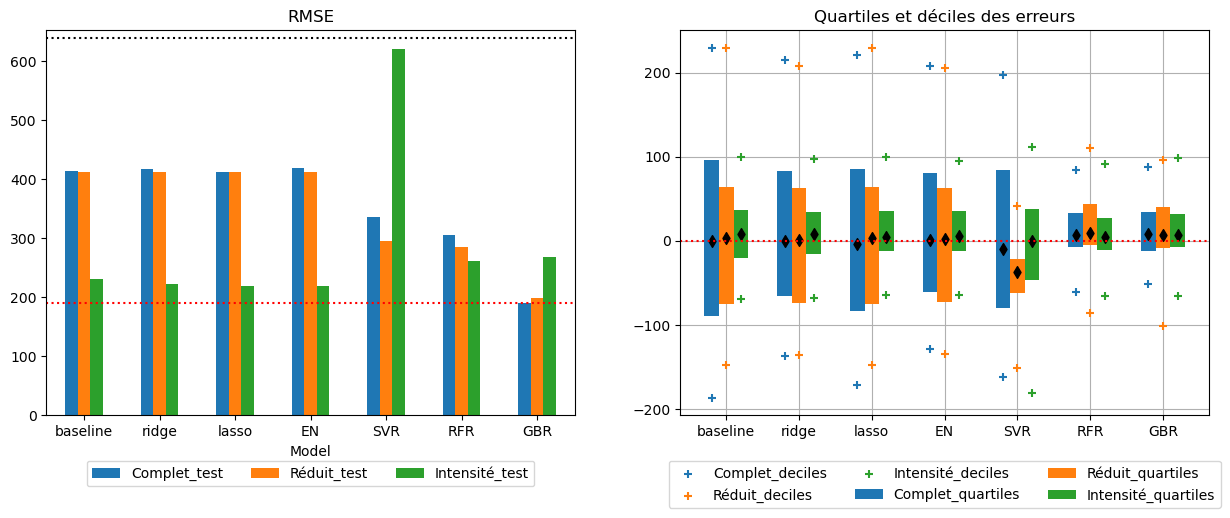

In [72]:
plot_RMSE_boxplot(y_test, model_std, ['Complet_test', 'Réduit_test', 'Intensité_test'],
                  q1_df, q3_df, d1_df, d9_df, median_df)

In [156]:
y_pred_final = Y_complet['GBR'].values
y_train_final = Y_train_complet['GBR'].values
clf_final = clf_complet['GBR']
model_final_name = 'GBR complet'

In [157]:
(y_train_final<0).sum()

58

In [158]:
(y_pred_final<0).sum()

28

In [159]:
y_pred_final = np.max(np.column_stack((y_pred_final, np.zeros(len(y_pred_final)))), axis=1)
y_train_final = np.max(np.column_stack((y_train_final, np.zeros(len(y_train_final)))), axis=1)

In [160]:
(y_train_final<0).sum()

0

In [161]:
(y_pred_final<0).sum()

0

#### RMSE et R2

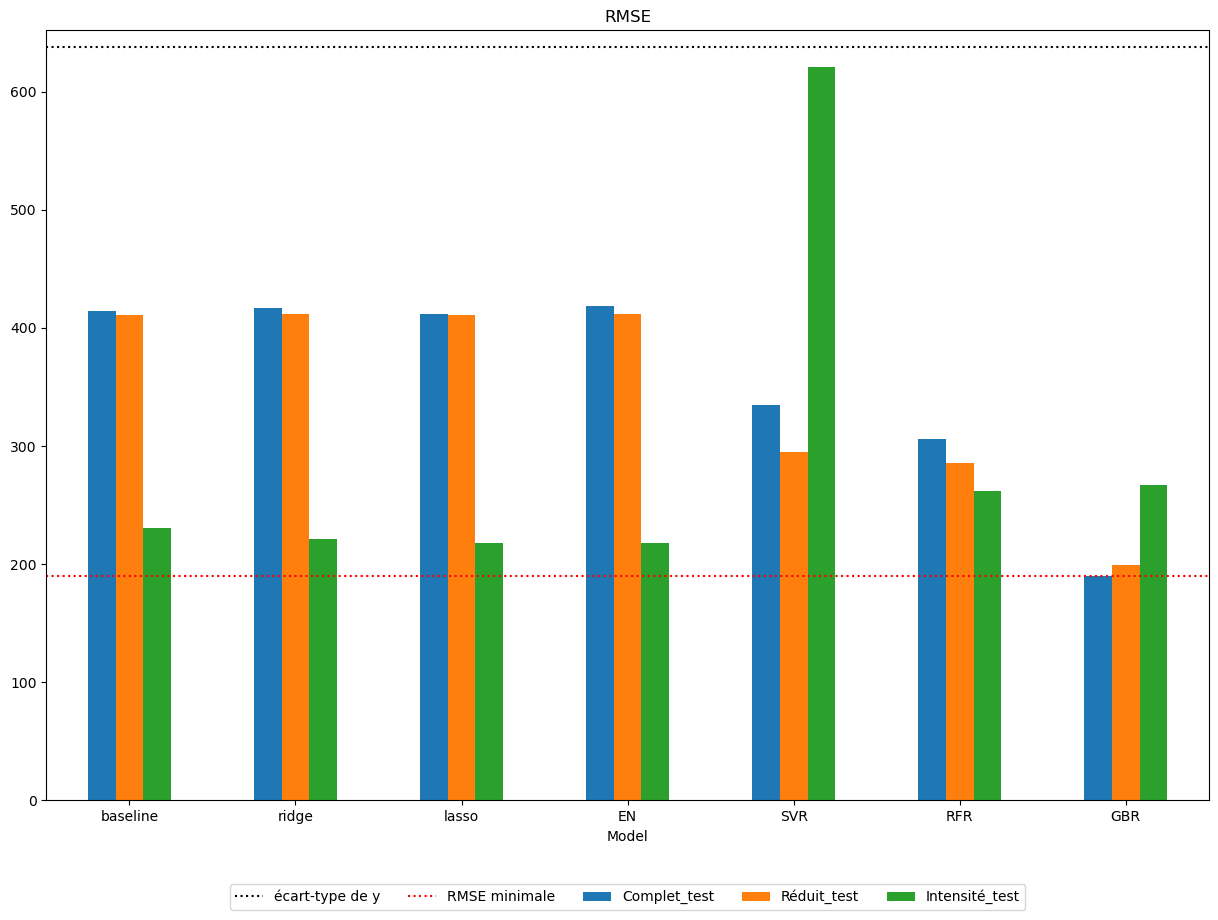

In [103]:
fig = plt.figure(figsize=(15,10))

ax=plt.subplot(1,1,1)
model_std.plot(ax=ax, kind='bar', x='Model', y=['Complet_test', 'Réduit_test', 'Intensité_test'], rot=0)
ax.axhline(np.std(y_test), color='k', linestyle=':', label="écart-type de y")
ax.axhline(np.nanmin(model_std[['Complet_test', 'Réduit_test', 'Intensité_test']].values), color='r', linestyle=':', label = 'RMSE minimale')
ax.set_title('RMSE')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)

plt.show()

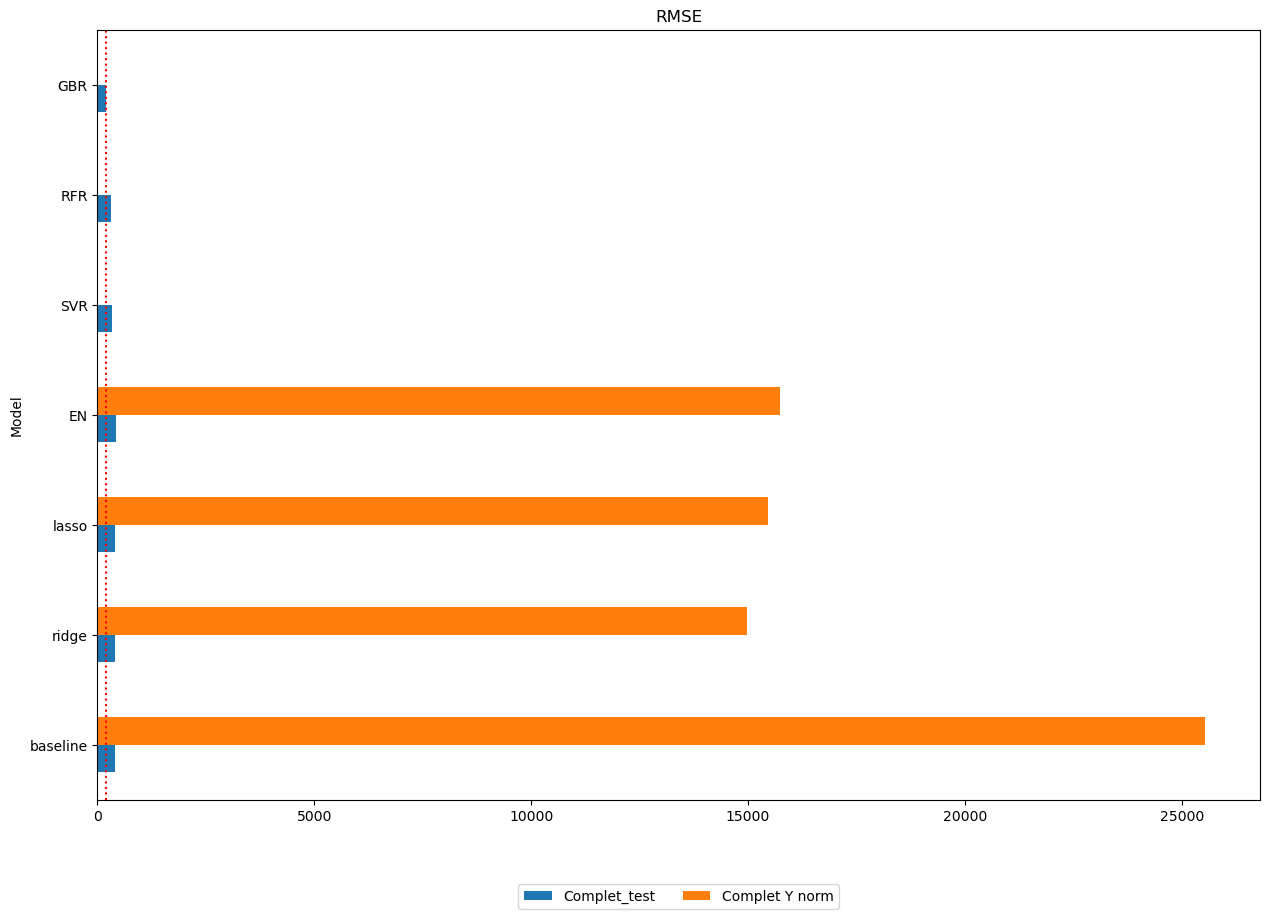

In [75]:
fig = plt.figure(figsize=(15,10))

ax=plt.subplot(1,1,1)
model_std.plot(ax=ax, kind='barh', x='Model', y=['Complet_test', 'Complet Y norm'])
ax.axvline(np.min(model_std[['Complet_test', 'Réduit_test', 'Intensité_test']].values), color='r', linestyle=':')
ax.set_title('RMSE')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

plt.show()

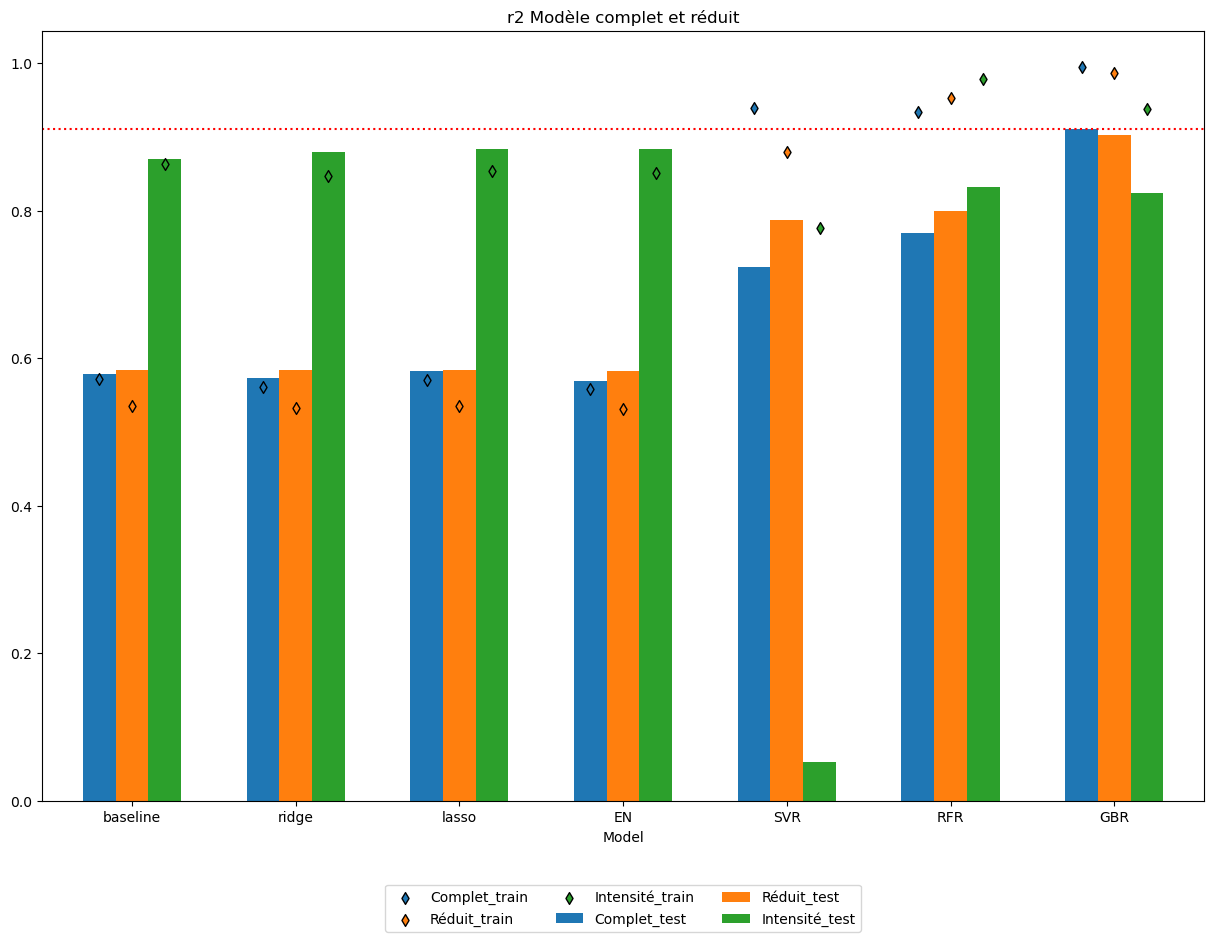

In [76]:
fig = plt.figure(figsize=(15,10))
ax=plt.subplot(1,1,1)
plot_r2(model_r2, ['Complet_test', 'Réduit_test', 'Intensité_test'], ['Complet_train', 'Réduit_train', 'Intensité_train'], ax)

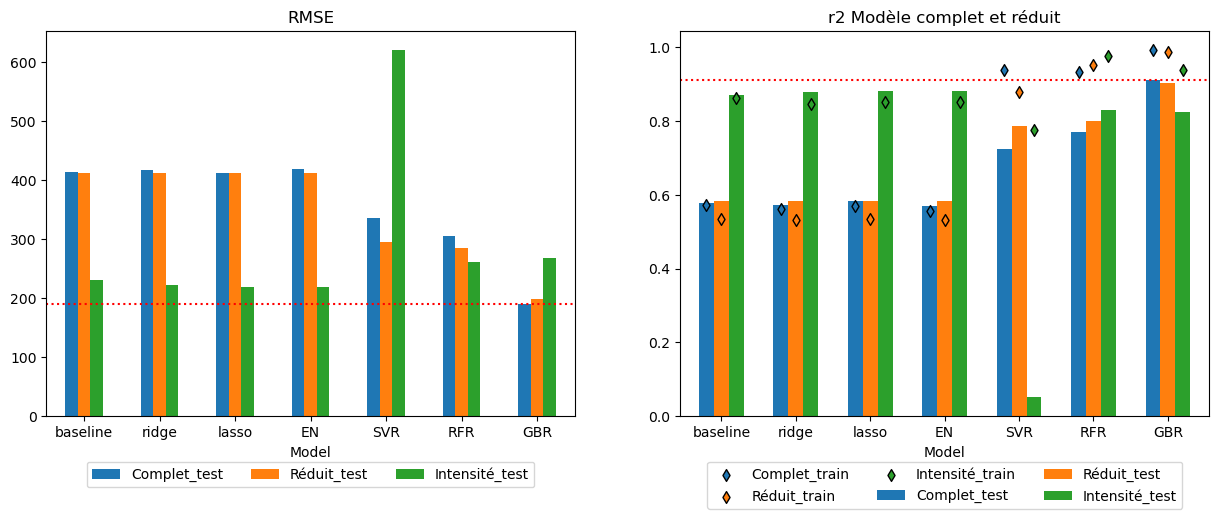

In [77]:
plot_RMSE_R2(model_std, model_r2, ['Complet_test', 'Réduit_test', 'Intensité_test'], ['Complet_train', 'Réduit_train', 'Intensité_train'])

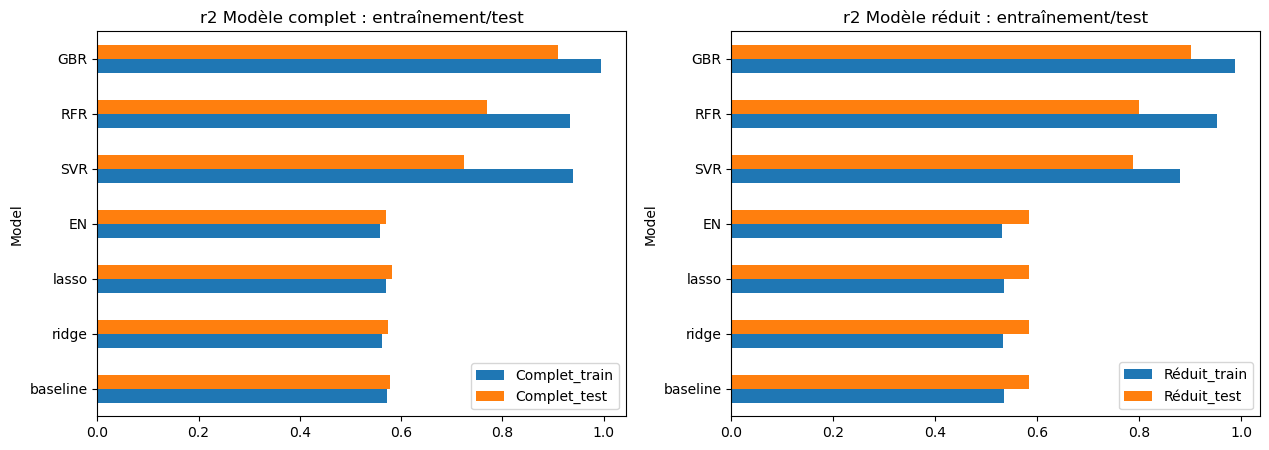

In [78]:
plot_compare(model_r2, ['Complet_train', 'Complet_test'], ['Réduit_train', 'Réduit_test'],
             'r2 Modèle complet : entraînement/test', 'r2 Modèle réduit : entraînement/test')

#### Paramètres

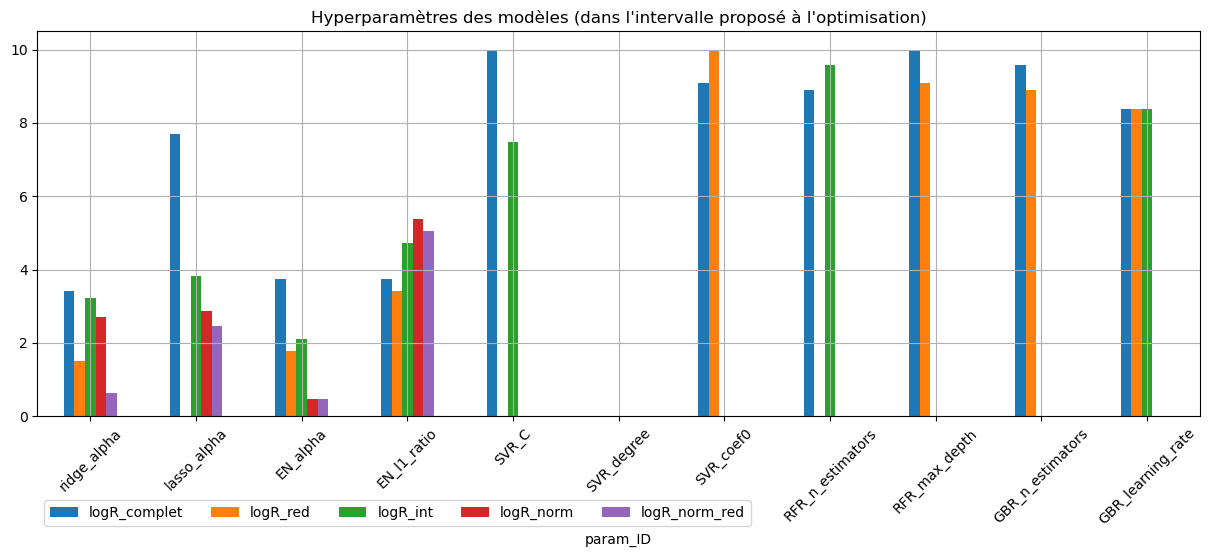

In [79]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,1,1)
model_params.plot.bar(ax=ax, x='param_ID', y=['logR_complet', 'logR_red', 'logR_int', 'logR_norm', 'logR_norm_red'], grid=True, rot=45)
plt.legend(loc='upper left', bbox_to_anchor=(0, -0.2), ncol=5)
plt.title('Hyperparamètres des modèles (dans l\'intervalle proposé à l\'optimisation)')
plt.show()

#### Répartition des erreurs

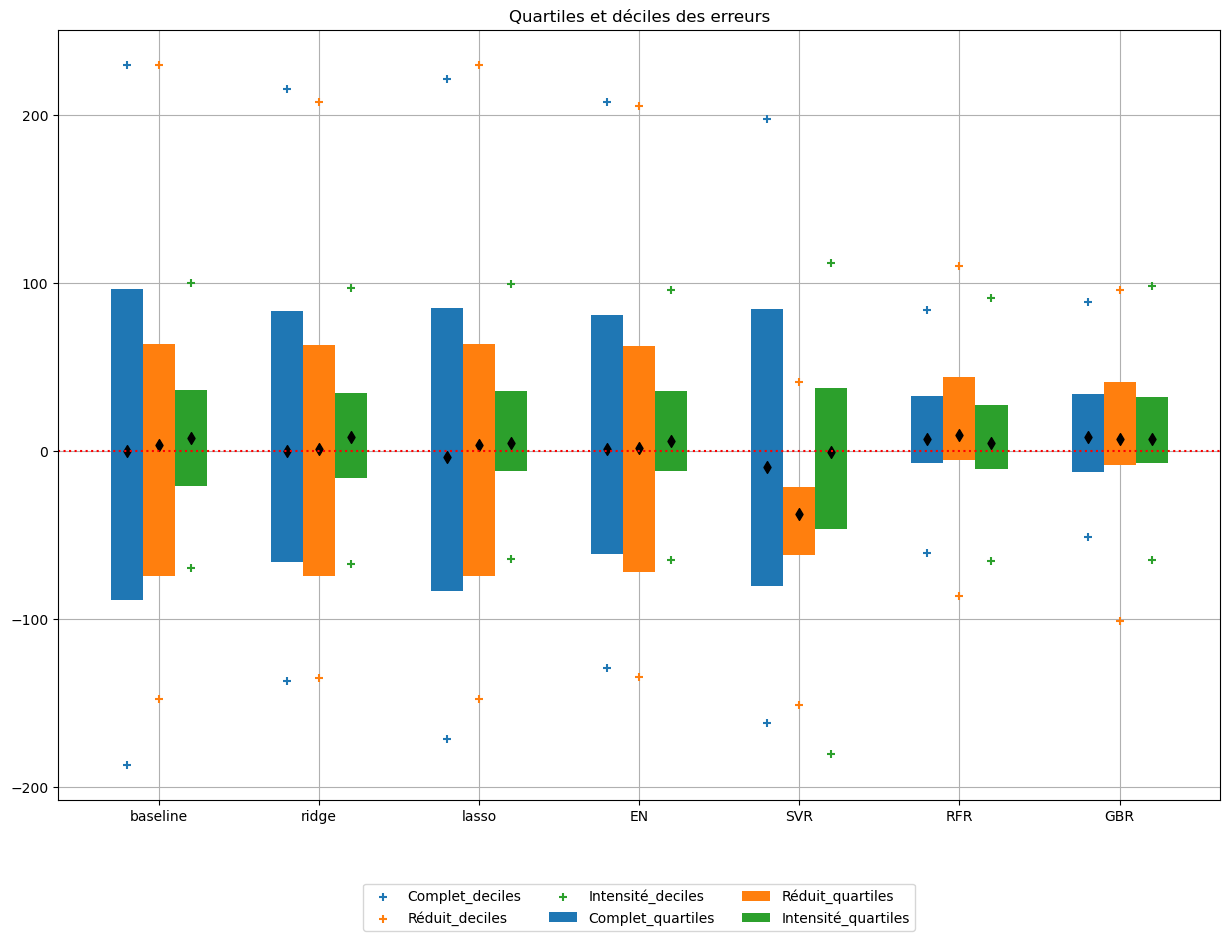

In [80]:
fig = plt.figure(figsize=(15,10))
ax=plt.subplot(1,1,1)
plot_boxplot(q1_df, q3_df, d1_df, d9_df, median_df, ax)

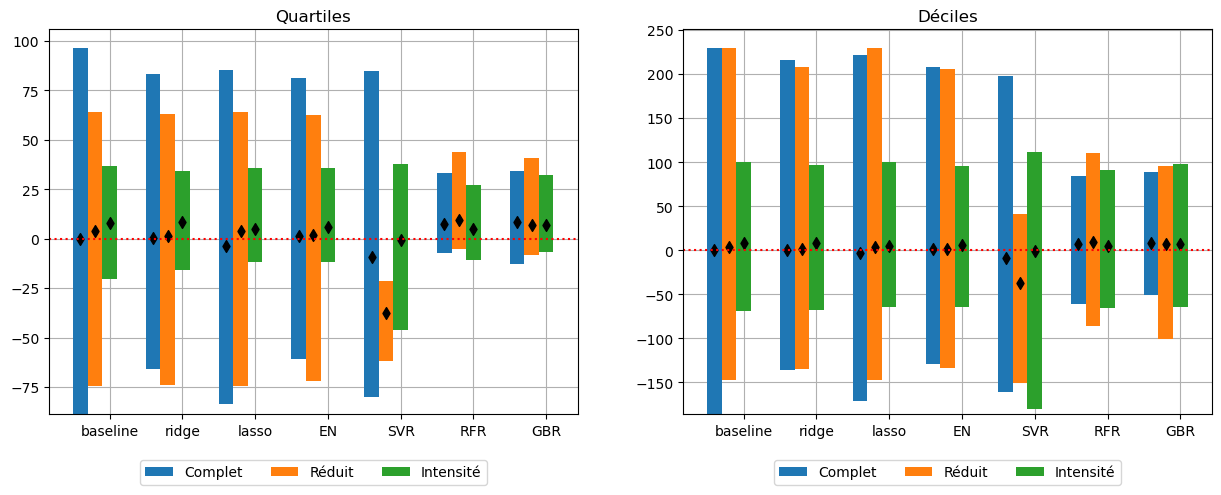

In [81]:
plot_quantiles(q1_df, q3_df, d1_df, d9_df, median_df)

#### Importance des features

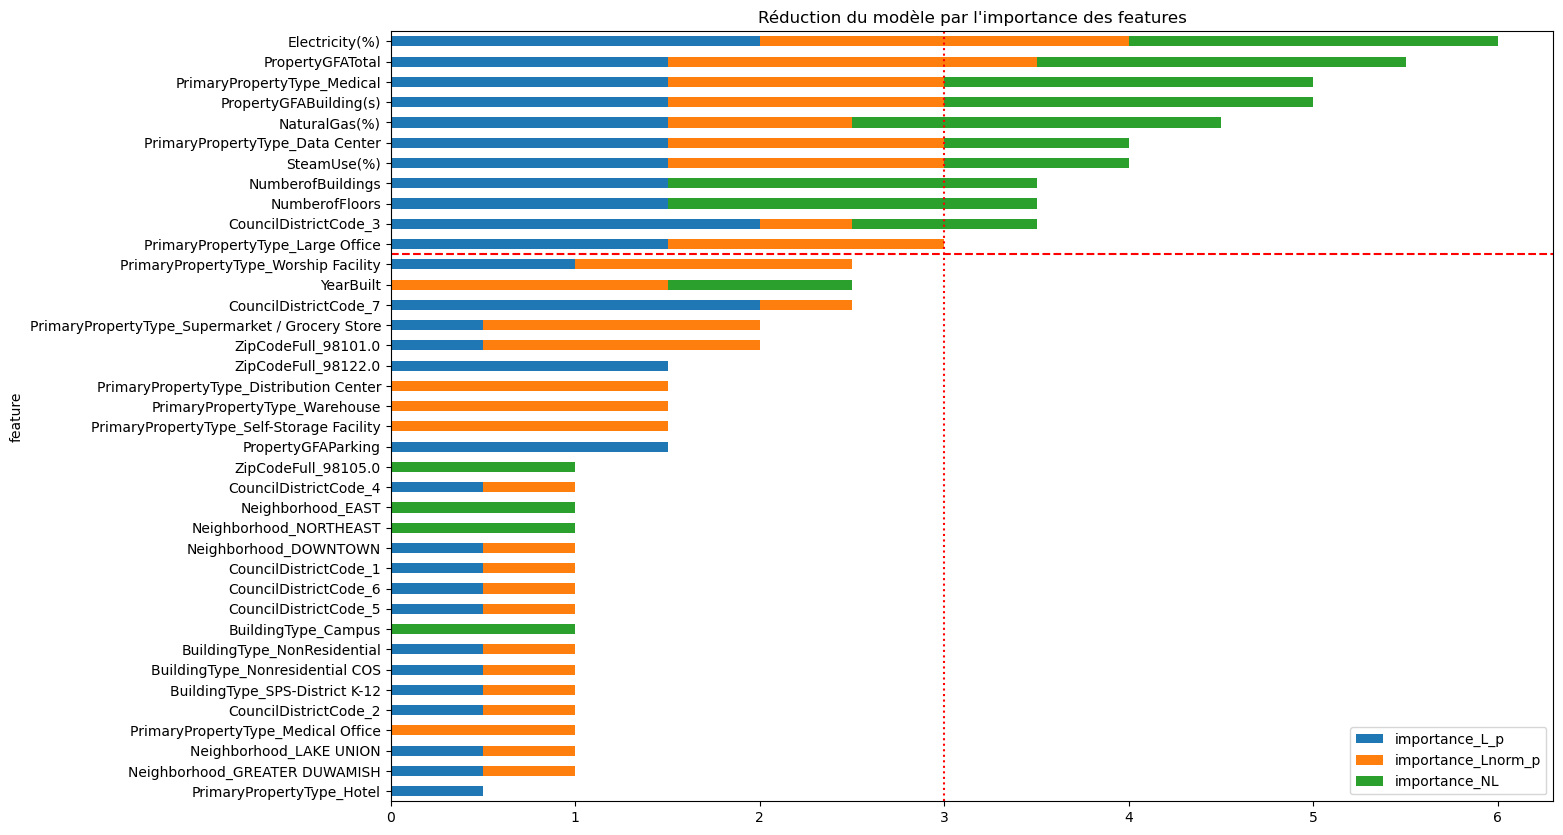

In [102]:
idx = np.argsort(feature_importances_df['importance_tot'])[::-1]
idx_max = next(x[0] for x in enumerate(feature_importances_df['importance_tot'][idx]) if x[1] < 3)

plt.figure(figsize=(15,10))

ax = plt.subplot(1,1,1)
feature_importances_df.loc[
feature_importances_df['importance_tot']>0
].sort_values('importance_tot').plot.barh(ax=ax, x='feature', y=['importance_L_p', 'importance_Lnorm_p', 'importance_NL'], stacked=True)
ax.axhline(len(feature_importances_df.loc[feature_importances_df['importance_tot']>0])-idx_max-0.5, linestyle='--', color='r')
ax.axvline(3, linestyle=':', color='r')
plt.title('Réduction du modèle par l\'importance des features')
plt.show()

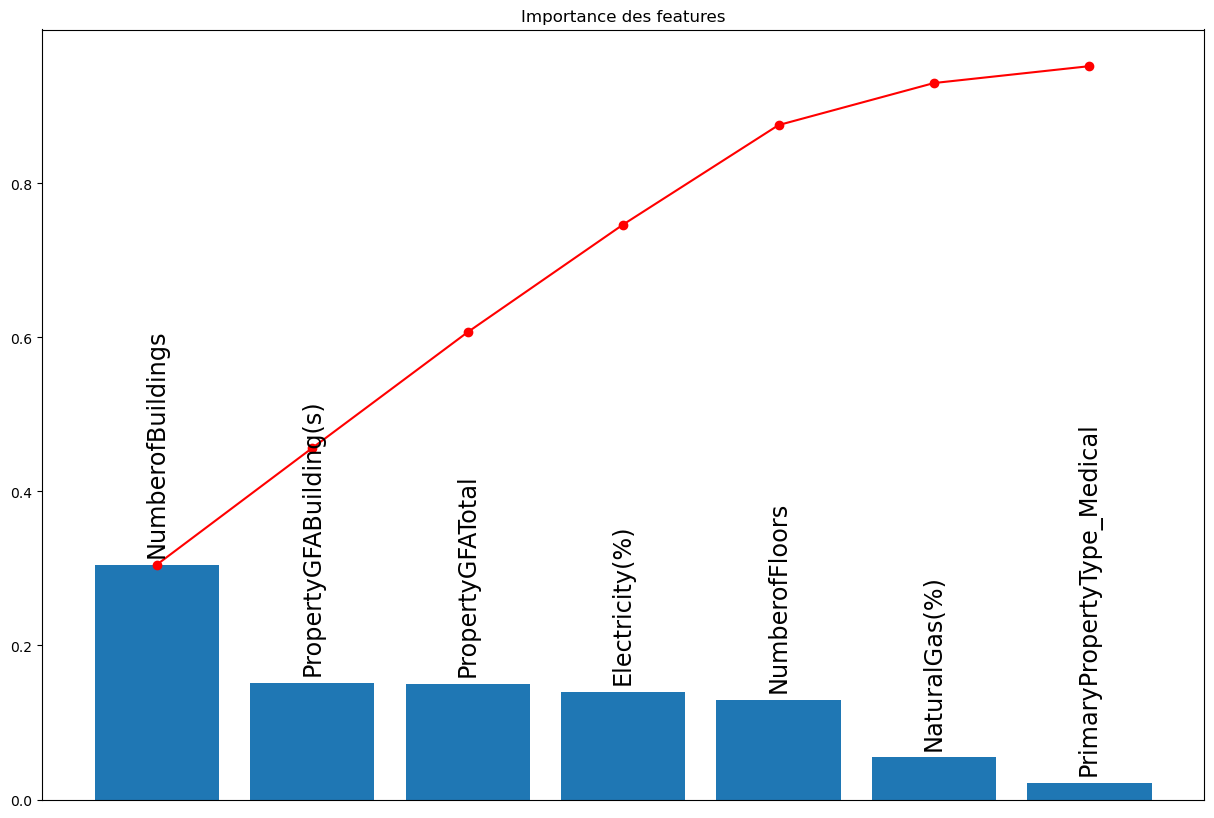

In [82]:
features_i = clf_final.best_estimator_.feature_importances_

idx = np.argsort(features_i)[::-1]
#std_fi = np.std([tree.feature_importances_ for tree in clf_gbr.best_estimator_.estimators_], axis=0)

cs = np.cumsum(features_i[idx])
idx_max = next(x[0] for x in enumerate(cs) if x[1] > 0.95)+1

fig = plt.figure(figsize=(15,10))

plt.bar(data_pred_variables[idx][0:idx_max], features_i[idx][0:idx_max])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
for i in range(idx_max):
    plt.text(i, features_i[idx][i]+0.01, data_pred_variables[idx][i], rotation=90, ha='center', va='bottom', size='xx-large')
plt.plot(data_pred_variables[idx][0:idx_max], cs[0:idx_max], 'o-r')
plt.title('Importance des features')
plt.show()

#### Représentation des prédictions

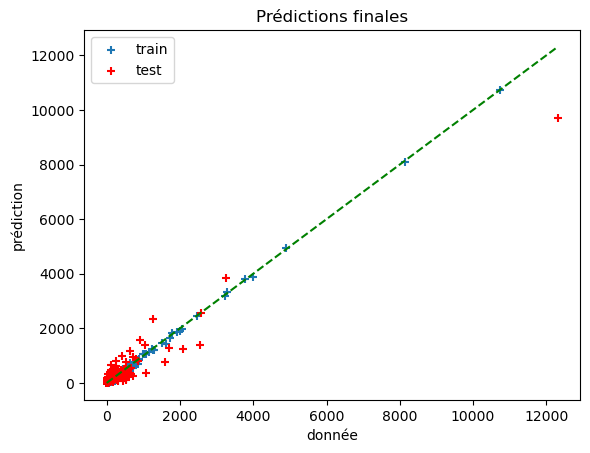

In [166]:
plt.scatter(x=y_train, y=y_train_final, marker='+', label='train')
plt.scatter(x=y_test, y=y_pred_final, marker='+', color='r', label='test')
plt.plot([0,max(data_pred[goal])], [0,max(data_pred[goal])],color='g', linestyle='--')
plt.title('Prédictions finales')
plt.xlabel('donnée')
plt.ylabel('prédiction')
plt.legend()
plt.show()

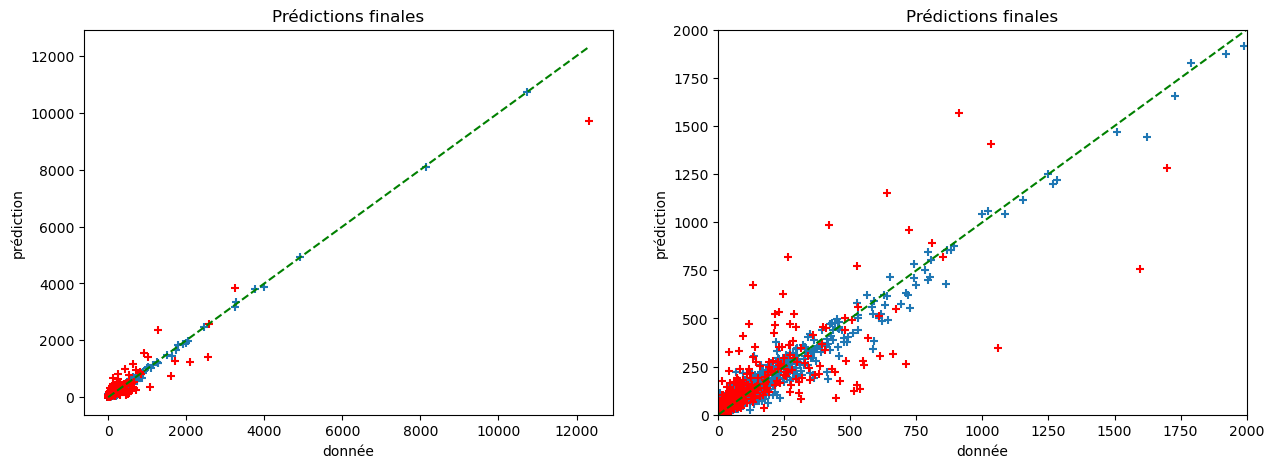

In [168]:
fig = plt.figure(figsize=(15,5))

ax=plt.subplot(1,2,1)
ax.scatter(x=y_train, y=y_train_final, marker='+')
ax.scatter(x=y_test, y=y_pred_final, marker='+', color='r')
ax.plot([0,max(data_pred[goal])], [0,max(data_pred[goal])],color='g', linestyle='--')
ax.set_title('Prédictions finales')
ax.set_xlabel('donnée')
ax.set_ylabel('prédiction')

ax=plt.subplot(1,2,2)
ax.scatter(x=y_train, y=y_train_final, marker='+')
ax.scatter(x=y_test, y=y_pred_final, marker='+', color='r')
ax.plot([0,max(data_pred[goal])], [0,max(data_pred[goal])],color='g', linestyle='--')
plt.xlim([0,2000])
plt.ylim([0, 2000])
ax.set_title('Prédictions finales')
ax.set_xlabel('donnée')
ax.set_ylabel('prédiction')

plt.show()

# Influence de l'ENERGYSTAR score

In [87]:
X_strat = data_pred_star.loc[:, data_pred_star.columns!='strat'].values
y_strat = data_pred_star['strat']

In [88]:
X_strat_train, X_strat_test, y_strat_train, y_strat_test = model_selection.train_test_split(X_strat, y_strat, stratify=y_strat, test_size=0.3)

In [89]:
data_pred_star_variables = np.concatenate((data_pred_variables, ['ENERGYSTARScore']))

In [90]:
data_star_pred_train = pd.DataFrame(data=X_strat_train, columns=data_pred_columns)
data_star_pred_test = pd.DataFrame(data=X_strat_test, columns=data_pred_columns)

In [91]:
Xs_train = data_star_pred_train[data_pred_variables].values
Xs_test = data_star_pred_test[data_pred_variables].values

In [92]:
Xs_star_train = data_star_pred_train[data_pred_star_variables].values
Xs_star_test = data_star_pred_test[data_pred_star_variables].values

In [93]:
ys_train = data_star_pred_train[goal].values
ys_test = data_star_pred_test[goal].values

In [94]:
ys_base_train, ys_base_test, clf_base = \
        prediction_clf(GradientBoostingRegressor(), Xs_train, ys_train, Xs_test, param_grid_dict['GBR'], score)

In [95]:
ys_star_train, ys_star_test, clf_star = \
        prediction_clf(GradientBoostingRegressor(), Xs_star_train, ys_train, Xs_star_test, param_grid_dict['GBR'], score)

In [96]:
r2_star_train = r2_score(ys_train, ys_star_train)
r2_star_test = r2_score(ys_test, ys_star_test)
r2_base_train = r2_score(ys_train, ys_base_train)
r2_base_test = r2_score(ys_test, ys_base_test)

In [97]:
std_star_test = math.sqrt(np.mean((ys_star_test - ys_test) **2))
std_base_test = math.sqrt(np.mean((ys_base_test - ys_test) **2))

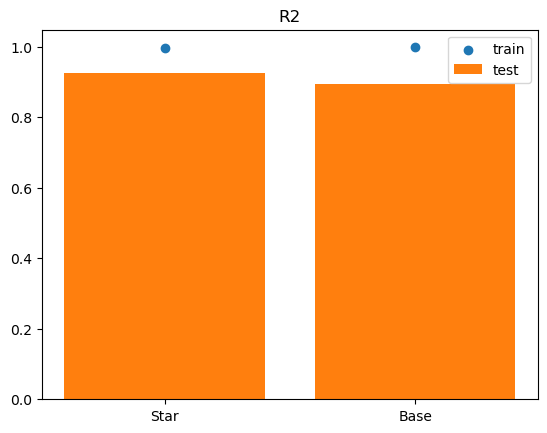

In [98]:
plt.scatter(x=['Star', 'Base'], y=[r2_star_train, r2_base_train], label='train')
plt.bar(x=['Star', 'Base'], height=[r2_star_test, r2_base_test], label='test')
plt.legend()
plt.title('R2')
plt.show()

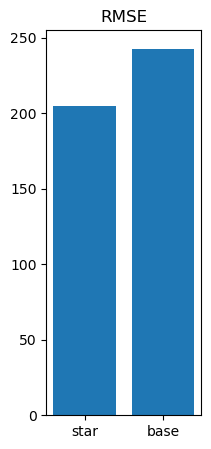

In [99]:
plt.figure(figsize=(2,5))
plt.bar(x=['star', 'base'], height=[std_star_test, std_base_test])
plt.title('RMSE')
plt.show()

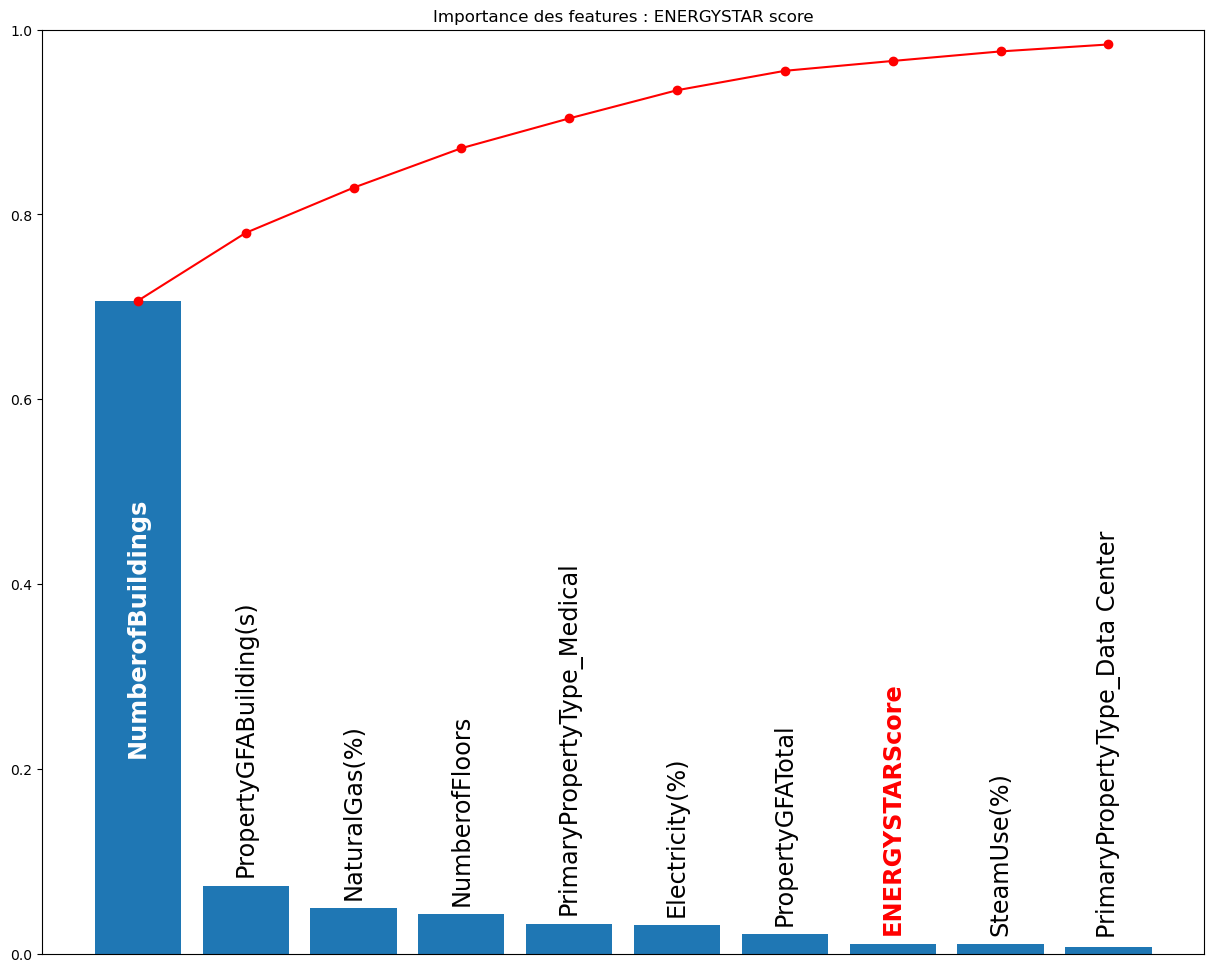

In [101]:
features_i = clf_star.best_estimator_.feature_importances_

idx = np.argsort(features_i)[::-1]
#std_fi = np.std([tree.feature_importances_ for tree in clf_gbr.best_estimator_.estimators_], axis=0)

cs = np.cumsum(features_i[idx])
idx_max = next(x[0] for x in enumerate(cs) if x[1] > 0.98)+1

fig = plt.figure(figsize=(15,12))

plt.bar(data_pred_star_variables[idx][0:idx_max], features_i[idx][0:idx_max])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.text(0, features_i[idx][0]/2, data_pred_star_variables[idx][0], rotation=90, ha='center', va='center', size='xx-large', color='w', weight='bold')
for i in range(1,idx_max):
    if(data_pred_star_variables[idx][i]=='ENERGYSTARScore'):
        plt.text(i, features_i[idx][i]+0.01, data_pred_star_variables[idx][i],
                 rotation=90, ha='center', va='bottom', size='xx-large', color='r', weight='bold')
    else:
        plt.text(i, features_i[idx][i]+0.01, data_pred_star_variables[idx][i], rotation=90, ha='center', va='bottom', size='xx-large')
plt.plot(data_pred_star_variables[idx][0:idx_max], cs[0:idx_max], 'o-r')
plt.ylim([0,1])
plt.title('Importance des features : ENERGYSTAR score')
plt.show()